In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import RobustScaler


In [7]:
df_resort = pd.read_csv('../Dataset/h1.csv')#Resort
df_city = pd.read_csv('../Dataset/h2.csv') #City

print("Shape of h1:", df_resort.shape)
print("Shape of h2:", df_city.shape)

df_resort['HotelType'] = 'Resort'
df_city['HotelType'] = 'City'

df = pd.concat([df_resort, df_city])
df.head()

Shape of h1: (40060, 31)
Shape of h2: (79330, 31)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelType
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,Resort
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,Resort
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,Resort
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,Resort
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,Resort


In [5]:
print(df['IsCanceled'].value_counts())

IsCanceled
0    75166
1    44224
Name: count, dtype: int64


## Data Analysis

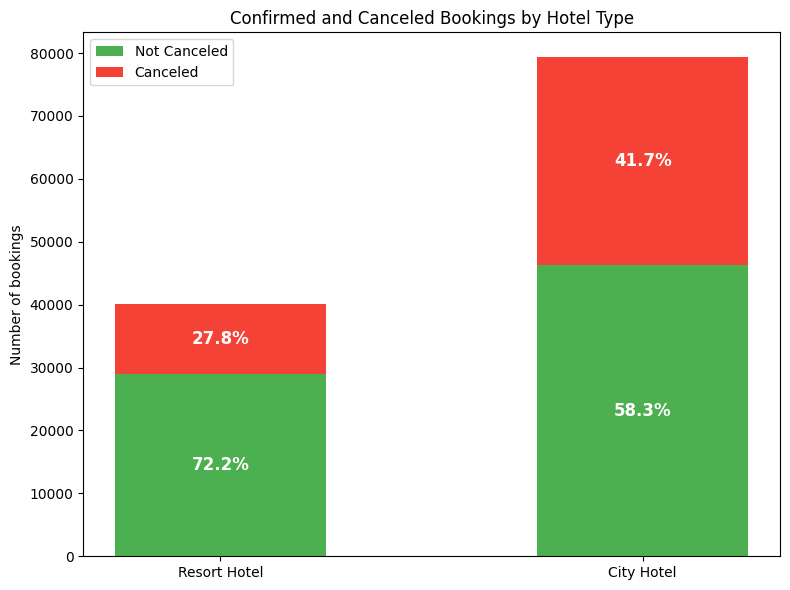

In [3]:
resort_counts = df_resort['IsCanceled'].value_counts().sort_index().reindex([0,1], fill_value=0)
city_counts = df_city['IsCanceled'].value_counts().sort_index().reindex([0,1], fill_value=0)

counts = np.array([resort_counts.values, city_counts.values])
percentages = counts / counts.sum(axis=1, keepdims=True) * 100


labels = ['Resort Hotel', 'City Hotel']
categories = ['Not Canceled', 'Canceled']
colors = ['#4CAF50', '#F44336']

fig, ax = plt.subplots(figsize=(8,6))
bar_width = 0.5
bar1 = ax.bar(labels, counts[:,0], bar_width, label='Confirmed', color=colors[0])
bar2 = ax.bar(labels, counts[:,1], bar_width, bottom=counts[:,0], label='Canceled', color=colors[1])

for i in range(len(labels)):
    ax.text(i, counts[i,0]/2, f"{percentages[i,0]:.1f}%", ha='center', va='center', color='white', fontsize=12, fontweight='bold')
    ax.text(i, counts[i,0] + counts[i,1]/2, f"{percentages[i,1]:.1f}%", ha='center', va='center', color='white', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of bookings')
ax.set_title('Confirmed and Canceled Bookings by Hotel Type')
ax.legend(categories)
plt.tight_layout()
plt.show()

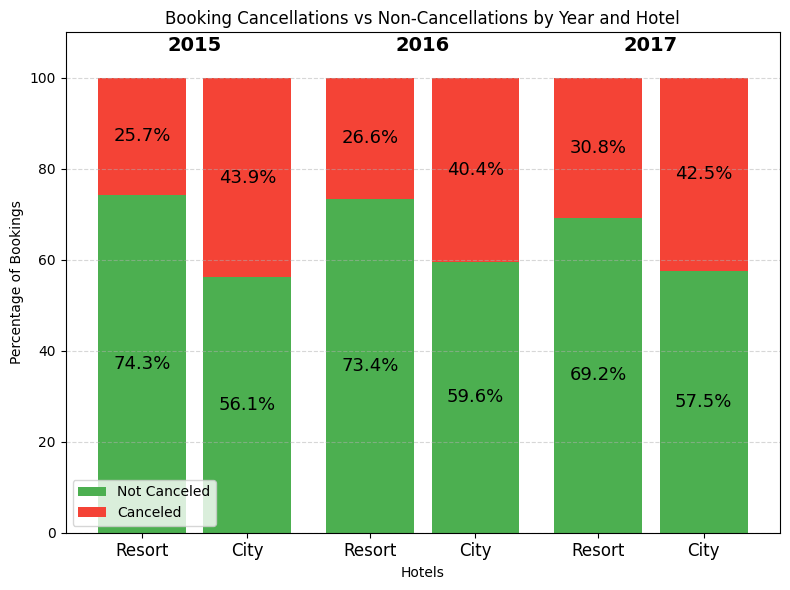

In [4]:
grouped = df.groupby(['ArrivalDateYear', 'HotelType', 'IsCanceled']).size().unstack(fill_value=0)

years = sorted(df['ArrivalDateYear'].unique())
bar_width = 0.5
inner_gap = 0.1 
outer_gap = 0.2  
positions = []
hotel_labels = ['Resort', 'City']
categories = ['Not Canceled', 'Canceled']


resort_not_canceled_pct = []
resort_canceled_pct = []
city_not_canceled_pct = []
city_canceled_pct = []

for year in years:
    # Resort
    if (year, 'Resort') in grouped.index:
        total = grouped.loc[(year, 'Resort')].sum()
        not_canceled = grouped.loc[(year, 'Resort')][0] if 0 in grouped.loc[(year, 'Resort')].index else 0
        canceled = grouped.loc[(year, 'Resort')][1] if 1 in grouped.loc[(year, 'Resort')].index else 0
        resort_not_canceled_pct.append(not_canceled / total * 100 if total > 0 else 0)
        resort_canceled_pct.append(canceled / total * 100 if total > 0 else 0)
    else:
        resort_not_canceled_pct.append(0)
        resort_canceled_pct.append(0)
    # City
    if (year, 'City') in grouped.index:
        total = grouped.loc[(year, 'City')].sum()
        not_canceled = grouped.loc[(year, 'City')][0] if 0 in grouped.loc[(year, 'City')].index else 0
        canceled = grouped.loc[(year, 'City')][1] if 1 in grouped.loc[(year, 'City')].index else 0
        city_not_canceled_pct.append(not_canceled / total * 100 if total > 0 else 0)
        city_canceled_pct.append(canceled / total * 100 if total > 0 else 0)
    else:
        city_not_canceled_pct.append(0)
        city_canceled_pct.append(0)

import pandas as pd
resort_not_canceled_pct = pd.Series(resort_not_canceled_pct, index=years)
resort_canceled_pct = pd.Series(resort_canceled_pct, index=years)
city_not_canceled_pct = pd.Series(city_not_canceled_pct, index=years)
city_canceled_pct = pd.Series(city_canceled_pct, index=years)


positions = []
for i, year in enumerate(years):
    base = i * (2 * bar_width + inner_gap + outer_gap)
    positions.extend([base, base + bar_width + inner_gap])

fig, ax = plt.subplots(figsize=(8, 6))


for i in range(len(years)):
    
    ax.bar(positions[2*i], resort_not_canceled_pct.iloc[i], bar_width, color='#4CAF50')
    ax.bar(positions[2*i], resort_canceled_pct.iloc[i], bar_width, bottom=resort_not_canceled_pct.iloc[i], color='#F44336')
    
    ax.bar(positions[2*i+1], city_not_canceled_pct.iloc[i], bar_width, color='#4CAF50')
    ax.bar(positions[2*i+1], city_canceled_pct.iloc[i], bar_width, bottom=city_not_canceled_pct.iloc[i], color='#F44336')
    
    ax.text(positions[2*i], resort_not_canceled_pct.iloc[i]/2, f'{resort_not_canceled_pct.iloc[i]:.1f}%', ha='center', va='center', color='black', fontsize=13)
    ax.text(positions[2*i], resort_not_canceled_pct.iloc[i] + resort_canceled_pct.iloc[i]/2, f'{resort_canceled_pct.iloc[i]:.1f}%', ha='center', va='center', color='black', fontsize=13)
    ax.text(positions[2*i+1], city_not_canceled_pct.iloc[i]/2, f'{city_not_canceled_pct.iloc[i]:.1f}%', ha='center', va='center', color='black', fontsize=13)
    ax.text(positions[2*i+1], city_not_canceled_pct.iloc[i] + city_canceled_pct.iloc[i]/2, f'{city_canceled_pct.iloc[i]:.1f}%', ha='center', va='center', color='black', fontsize=13)


xticks = []
xticklabels = []
for i, year in enumerate(years):
    xticks.extend([positions[2*i], positions[2*i+1]])
    xticklabels.extend(hotel_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=12)


for i, year in enumerate(years):
    xpos = (positions[2*i] + positions[2*i+1]) / 2
    ax.text(xpos, 105, str(year), ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylim(0, 110)
ax.set_ylabel('Percentage of Bookings')
ax.set_xlabel('Hotels')
ax.set_title('Booking Cancellations vs Non-Cancellations by Year and Hotel')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(categories)
plt.tight_layout()
plt.show()

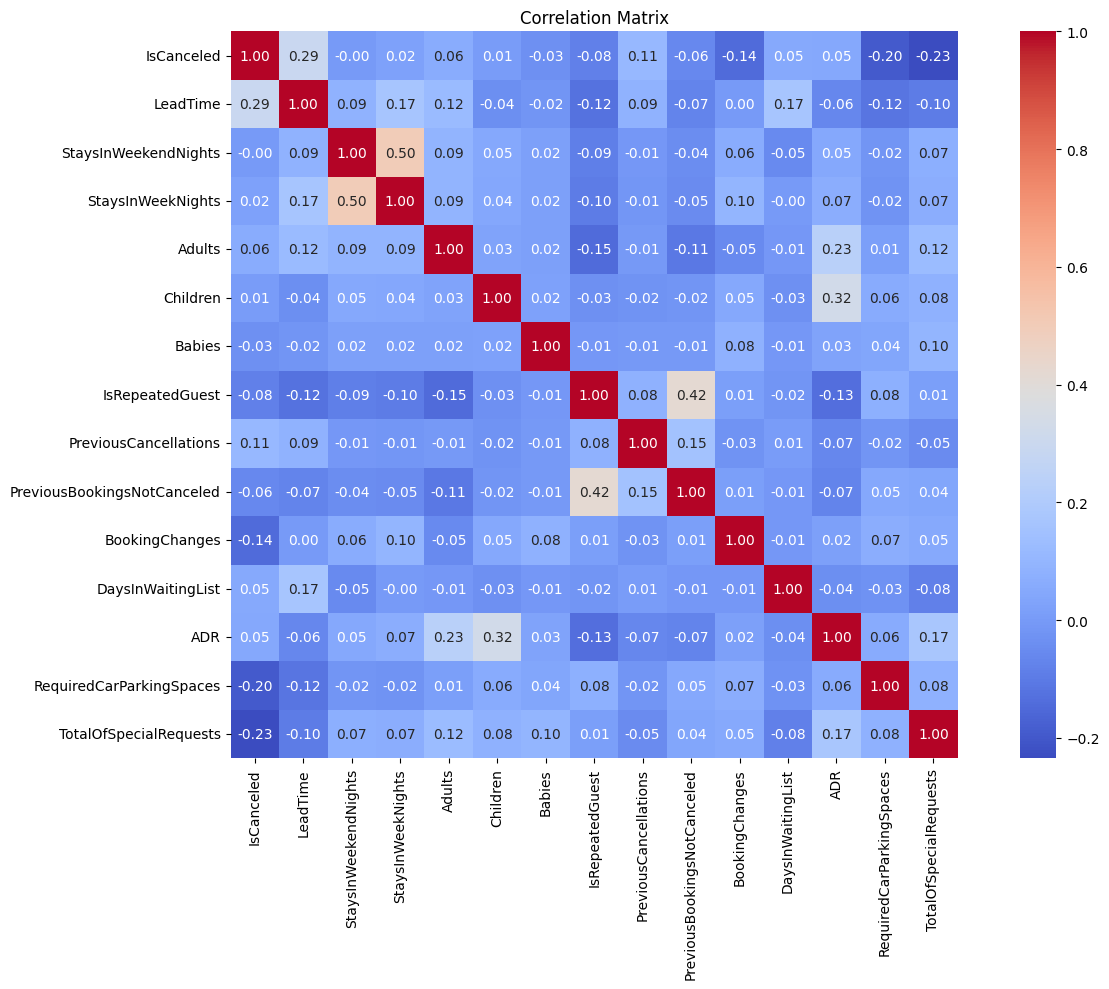

In [5]:
exclude = [
    'ArrivalDateYear',
    'ArrivalDateWeekNumber',
    'ArrivalDateDayOfMonth',
    'IsReapetedGuest'
]


cols_to_keep = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude]


corr_matrix = df[cols_to_keep].corr()


plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd


exclude_cols = ['IsCanceled', 'ReservationStatusDate', 'ArrivalDateMonth', 'ArrivalDateDayOfWeek', 'ArrivalDateDayOfMonth', 'ArrivalDateWeekNumber', 'ArrivalDateYear']

categorical_vars = [
    col for col in df.columns
    if col not in exclude_cols and (
        df[col].dtype == 'object' or
        df[col].dtype == 'bool' or
        (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() <= 10)
    )
]


for var in categorical_vars:
    table = pd.crosstab(df['IsCanceled'], df[var])
    if table.shape[0] > 1 and table.shape[1] > 1:  
        chi2, p, dof, expected = chi2_contingency(table)
        print(f"{var}: p-value = {p}")


Children: p-value = 1.9847826203224402e-20
Babies: p-value = 1.7724542727954542e-29
Meal: p-value = 1.3212351959124216e-64
Country: p-value = 0.0
MarketSegment: p-value = 0.0
DistributionChannel: p-value = 0.0
IsRepeatedGuest: p-value = 1.7841252215934033e-188
ReservedRoomType: p-value = 1.121956218424043e-133
AssignedRoomType: p-value = 0.0
DepositType: p-value = 0.0
Agent: p-value = 0.0
Company: p-value = 1.735516389189018e-297
CustomerType: p-value = 0.0
RequiredCarParkingSpaces: p-value = 0.0
TotalOfSpecialRequests: p-value = 0.0
ReservationStatus: p-value = 0.0
HotelType: p-value = 0.0


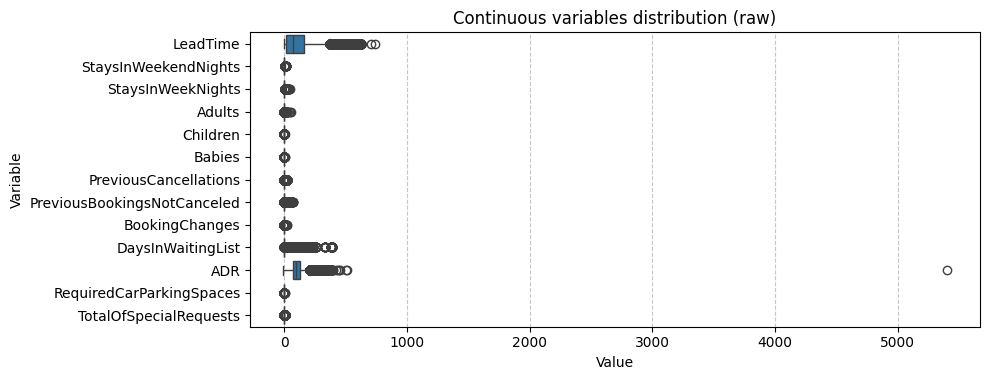

In [ ]:
exclude = ['IsCanceled', 'ArrivalDateYear', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'IsRepeatedGuest']
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in exclude]

df_melted = df[numeric_cols].melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(10, len(numeric_cols) * 0.3))
sns.boxplot(data=df_melted, y='Variable', x='Value', orient='h', showfliers=True)
plt.title("Continuous variables distribution (raw)")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

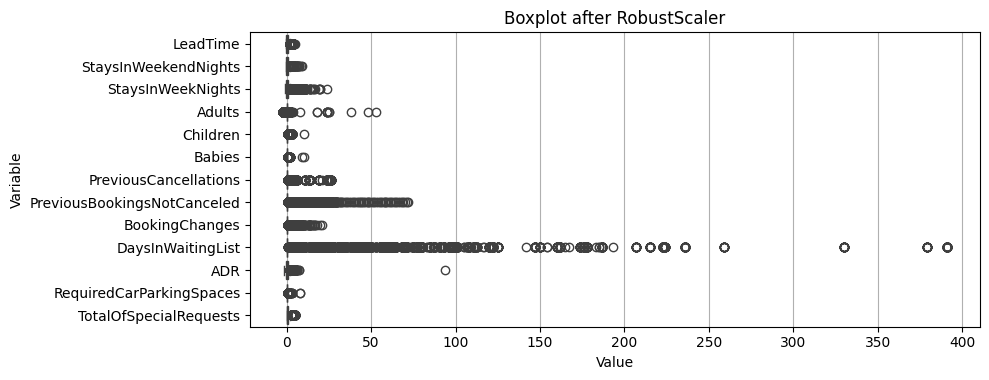

In [8]:

scaler = RobustScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

df_melted = scaled_df.melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(10, len(numeric_cols) * 0.3))
sns.boxplot(data=df_melted, y='Variable', x='Value', orient='h', showfliers=True)
plt.title("Boxplot after RobustScaler")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

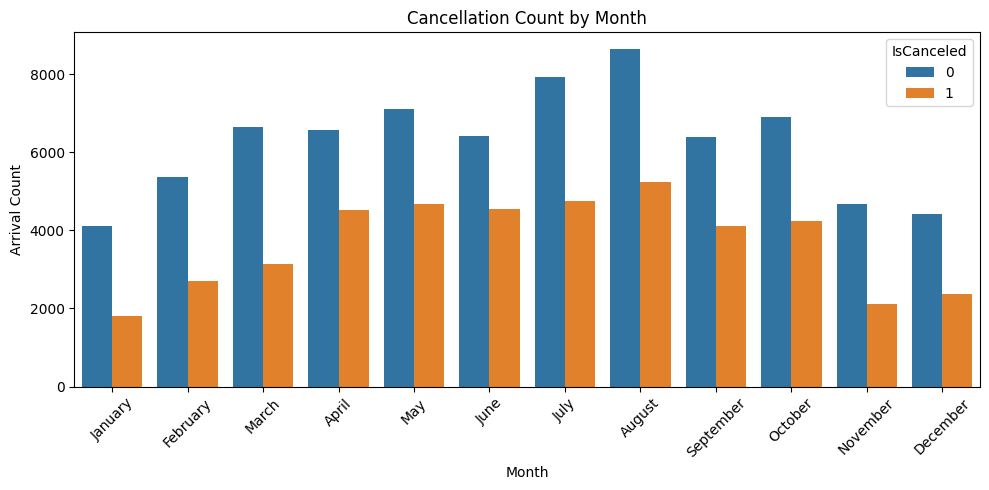

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x='ArrivalDateMonth', hue='IsCanceled', data=df, order=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Cancellation Count by Month')
plt.xlabel('Month')
plt.ylabel('Arrival Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

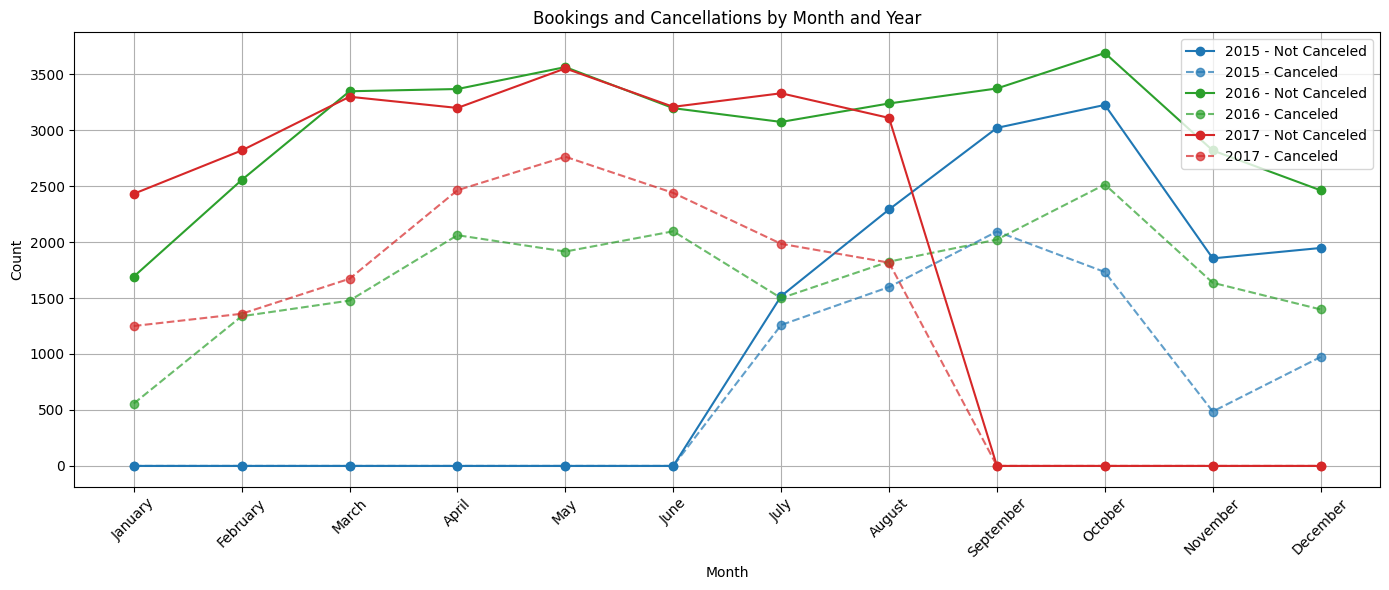

In [16]:

monthly_data = df.groupby(['ArrivalDateYear', 'ArrivalDateMonth', 'IsCanceled']).size().reset_index(name='Count')


month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_data['ArrivalDateMonth'] = pd.Categorical(monthly_data['ArrivalDateMonth'], categories=month_order, ordered=True)

pivot = monthly_data.pivot_table(index=['ArrivalDateYear', 'IsCanceled'], columns='ArrivalDateMonth', values='Count', fill_value=0,observed=False)

year_colors = {
    2015: '#1f77b4',  
    2016: '#2ca02c',  
    2017: '#d62728',  
}

plt.figure(figsize=(14, 6))

for (year, cancel_status), row in pivot.iterrows():
    color = year_colors.get(year, '#333333')
    label = f"{year} - {'Not Canceled' if cancel_status == 0 else 'Canceled'}"
    linestyle = '-' if cancel_status == 0 else '--'
    plt.plot(month_order, row.values, marker='o', label=label, linestyle=linestyle, color=color, alpha=1 if cancel_status == 0 else 0.7)

plt.title('Bookings and Cancellations by Month and Year')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

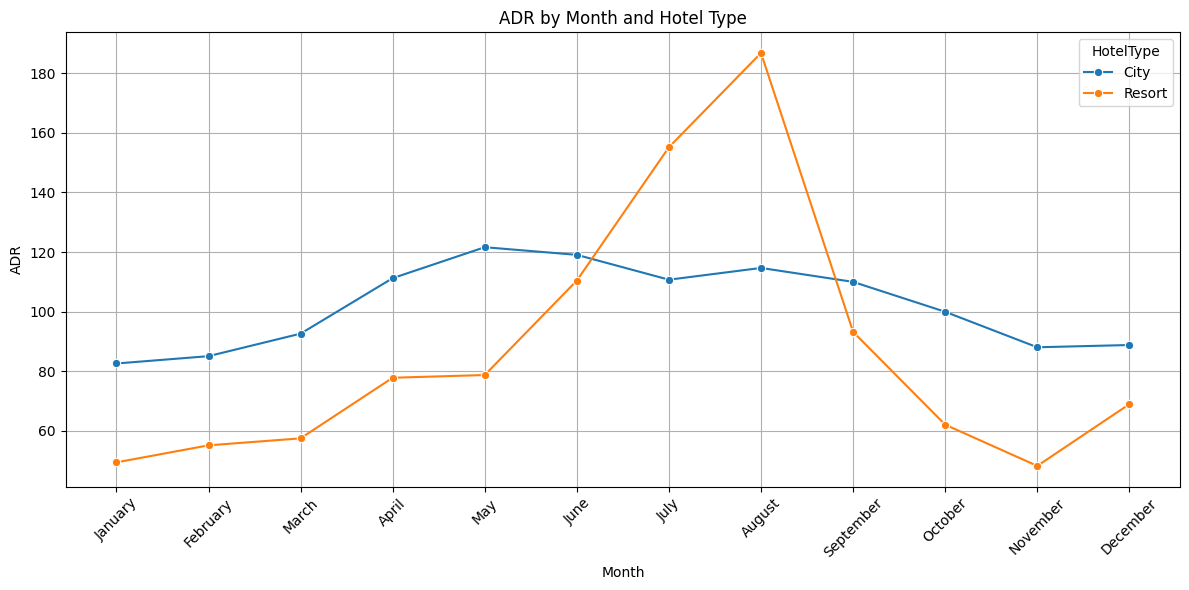

In [17]:
avg_price_per_month = df.groupby(['HotelType', 'ArrivalDateMonth'])['ADR'].mean().reset_index()

avg_price_per_month['ArrivalDateMonth'] = pd.Categorical(avg_price_per_month['ArrivalDateMonth'], categories=month_order, ordered=True)
avg_price_per_month = avg_price_per_month.sort_values('ArrivalDateMonth')

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_per_month, x='ArrivalDateMonth', y='ADR', hue='HotelType', marker='o')
plt.title('ADR by Month and Hotel Type')
plt.xlabel('Month')
plt.ylabel('ADR')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


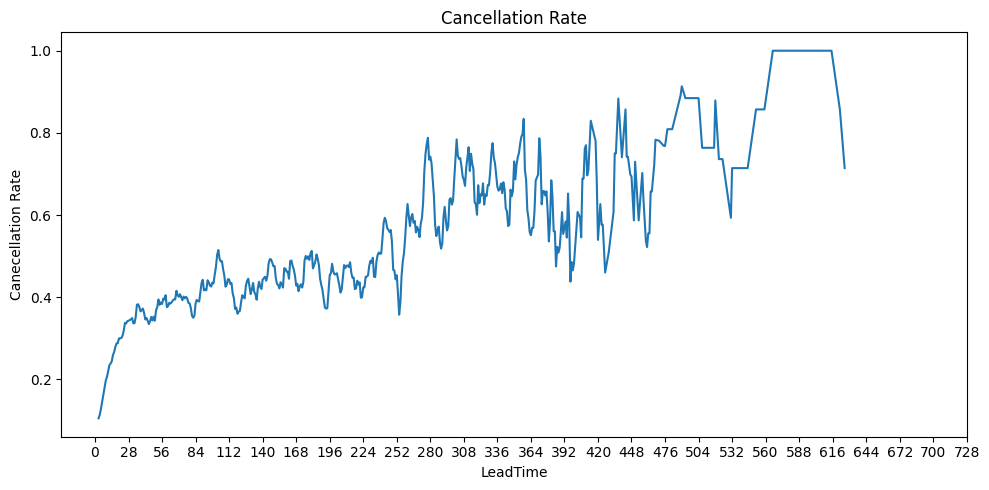

In [12]:
lead_df = df.groupby('LeadTime')['IsCanceled'].mean().reset_index()
lead_df['RollingMean'] = lead_df['IsCanceled'].rolling(window=7, center=True).mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=lead_df, x='LeadTime', y='RollingMean')
plt.title('Cancellation Rate')
plt.xlabel('LeadTime')
plt.ylabel('Canecellation Rate')
plt.xticks(np.arange(0, df['LeadTime'].max()+1, step=28))  
plt.tight_layout()
plt.show()

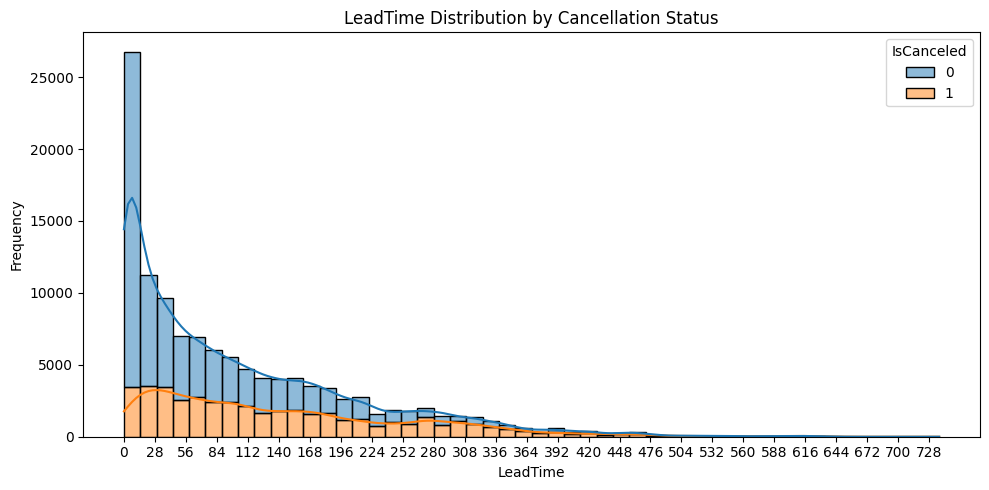

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='LeadTime', hue='IsCanceled', bins=50, kde=True, multiple='stack')
plt.title('LeadTime Distribution by Cancellation Status')
plt.xlabel('LeadTime')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, df['LeadTime'].max()+1, step=28))
plt.tight_layout()
plt.show()

In [14]:
mean_leadtime_canceled = df[df['IsCanceled'] == 1]['LeadTime'].mean()

mean_leadtime_canceled_resort = df[(df['IsCanceled'] == 1) & (df['HotelType'] == 'Resort')]['LeadTime'].mean()

mean_leadtime_canceled_city = df[(df['IsCanceled'] == 1) & (df['HotelType'] == 'City')]['LeadTime'].mean()

print(f"Global Mean LeadTime for canceled bookings: {mean_leadtime_canceled:.2f}")
print(f"Resort Hotel LeadTime Mean for canceled bookings: {mean_leadtime_canceled_resort:.2f}")
print(f"City Hotel LeadTime Mean for canceled bookings: {mean_leadtime_canceled_city:.2f}")

Global Mean LeadTime for canceled bookings: 144.85
Resort Hotel LeadTime Mean for canceled bookings: 128.68
City Hotel LeadTime Mean for canceled bookings: 150.28


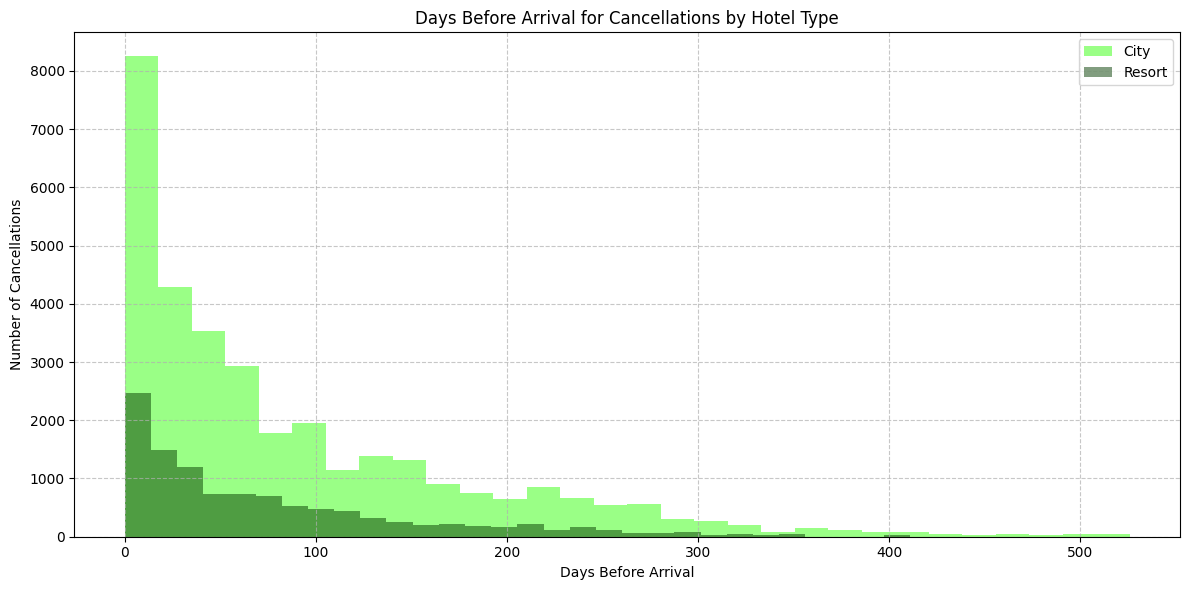

In [15]:
canceled = df[df['IsCanceled'] == 1].copy()

canceled['ArrivalDate'] = pd.to_datetime(
    canceled['ArrivalDateYear'].astype(str) + '-' +
    canceled['ArrivalDateMonth'].astype(str) + '-' +
    canceled['ArrivalDateDayOfMonth'].astype(str),
    errors='coerce'
)
canceled['CancellationDate'] = pd.to_datetime(canceled['ReservationStatusDate'], errors='coerce')

canceled['DaysBeforeArrivalCanceled'] = (canceled['ArrivalDate'] - canceled['CancellationDate']).dt.days
canceled = canceled[canceled['DaysBeforeArrivalCanceled'].notnull() & (canceled['DaysBeforeArrivalCanceled'] >= 0)]

plt.figure(figsize=(12, 6))

sns.histplot(
    data=canceled[canceled['HotelType'] == 'City'],
    x='DaysBeforeArrivalCanceled',
    label='City',
    bins=30,
    color="#36ff0e",
    alpha=0.5,
    edgecolor=None 
)
sns.histplot(
    data=canceled[canceled['HotelType'] == 'Resort'],
    x='DaysBeforeArrivalCanceled',
    label='Resort',
    bins=30,
    color="#053d00",
    alpha=0.5,
    edgecolor=None 
)


plt.title("Days Before Arrival for Cancellations by Hotel Type")
plt.xlabel("Days Before Arrival")
plt.ylabel("Number of Cancellations")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()